# Problem and Data Description

Cancer is one of the leading causes of death worldwide. It is the second most common cause of death in the United States. Early detection is very important in the fight to beat cancer. One way to discover cancer is pathology scans. Here we will use machine learning to look at pathology scans and identify metastatic cancer.
The data used is a slightly modified version of the PatchCamelyon benchmark dataset. This dataset removes duplicate images from the orginial dataset. The images are 96x96 pixels, each has an identifying id, and a label: 1 for cancerous, 0 for not. If one pixel in the image is cancerous, then the entire image is labeled as 1. The data has no missing values and is already split into training and testing datasets, with 80% of the data in the train set (220,025 images), and the remaining 20% in the test set. 

# Exploratory Data Analysis

Load needed libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage import io
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Load data:

In [2]:
train_path = "../input/histopathologic-cancer-detection/train/"
test_path = "../input/histopathologic-cancer-detection/test/"
sample_submission = pd.read_csv("../input/histopathologic-cancer-detection/sample_submission.csv")
train_labels = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")

Data exploration:

In [33]:
# Initial look
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [34]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


The info above shows the two variables: id is the image object and label is the integer label (1 for cancerous, 0 for not). We see that there are no missing values, so the data is already clean.

In [35]:
train_labels.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Basic statistics show that there are more '0' labels than '1' labels. We will see this further in the bar plot below.

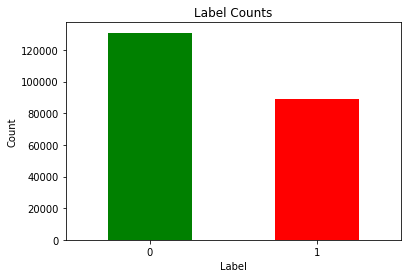

In [36]:
# Label Count Barplot
train_labels['label'].value_counts().plot(kind='bar', rot=0, color=['Green','Red'])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Counts")
plt.show()

The barplot shows around 13,000 '0' labels and around 8,000 '1' labels. This data is not a 50/50 split, but considering there are 22,0025 images with approximately a 60/40 split, we can be confident this slight skewness won't have an effect when it comes to building our models.

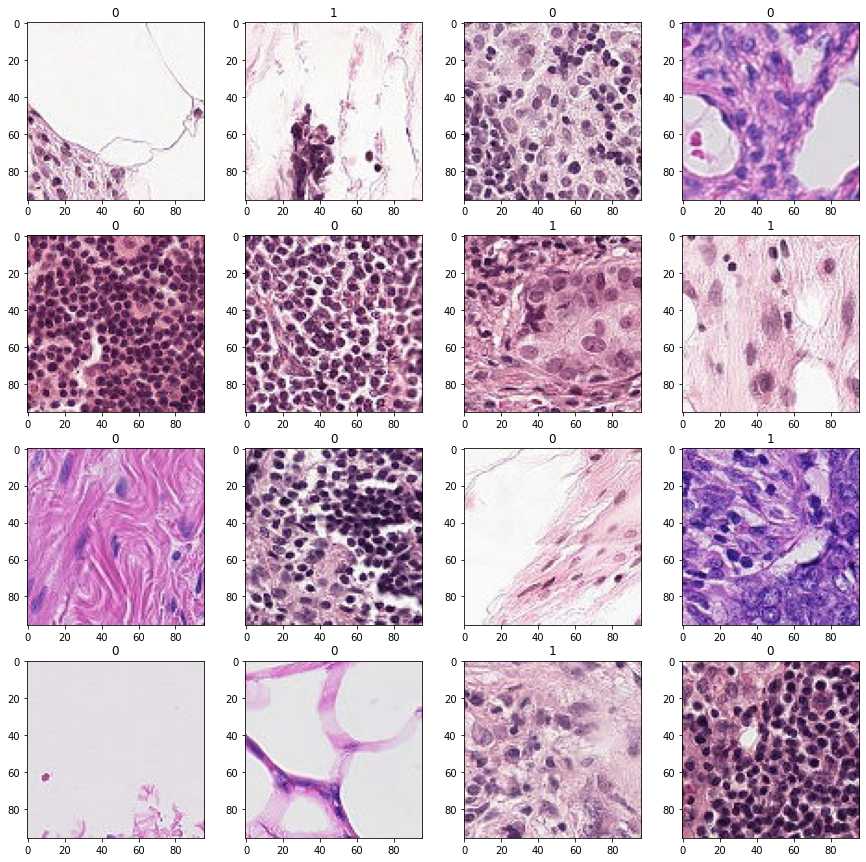

In [37]:
# Pathology images
fig, ax = plt.subplots(4,4, figsize = (15,15))
for i, axis in enumerate(ax.flat):
    image = io.imread(str(train_path + train_labels['id'][i] + '.tif'))
    axis.imshow(image)
    axis.set(title = train_labels['label'][i])

16 of the images are plotted above with the titles of each plot telling us if there is cancer present (titled '1') or not (titled '0'). As a data scientist and not a medical professional, we do not understand these images, much less be able to identify cancer just by looking at it, which is why we use machine learning to analyze the images.

Before we perform machine learning and build any models, we must make sure our data is ready. As the images are 'tif' files, we will append the format '.tif' to the image ids, and the labels must be a string. The data also needs to be split into training and testing datasets in order to train our models and then test them. The data will also get normalized.

In [3]:
train_labels['id'] = train_labels['id'] + '.tif'
train_labels['label'] = train_labels['label'].astype(str)
data_train, data_valid = train_test_split(train_labels, test_size=0.2, random_state=42)
data_gen = ImageDataGenerator(rescale = 1/255)
train_gen = data_gen.flow_from_dataframe(dataframe=data_train, directory=train_path, x_col='id', 
                                         y_col='label', batch_size=128, seed=42, shuffle=True, 
                                         class_mode='binary', target_size=(96,96))
valid_gen = data_gen.flow_from_dataframe(dataframe=data_valid, directory=train_path, x_col='id', 
                                         y_col='label', batch_size=128, seed=42, shuffle=True, 
                                         class_mode='binary', target_size=(96,96))

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Now that the data is ready to go, we can begin building models.

# Model Architecture

For the first model, we will constuct a fairly simple model. There will be 3 sets of 2 convolutional layers, the number of filters for each set will be 16, 32, 64 all of size 3x3 with a stride of 1. At each set there will also be a max pooling layer of size 2x2. After these 3 sets of layers, there will be a final layer that uses sigmoid activation. I chose a small filter and pooling size and a stride of 1 because the images are relatively small (96x96 pixels).

In [17]:
# First Model

model_1 = Sequential()

model_1.add(Conv2D(filters = 16, kernel_size = (3,3)))
model_1.add(Conv2D(filters = 16, kernel_size = (3,3)))
model_1.add(MaxPooling2D(pool_size = (2,2)))

model_1.add(Conv2D(filters = 32, kernel_size = (3,3)))
model_1.add(Conv2D(filters = 32, kernel_size = (3,3)))
model_1.add(MaxPooling2D(pool_size = (2,2)))

model_1.add(Conv2D(filters = 64, kernel_size = (3,3)))
model_1.add(Conv2D(filters = 64, kernel_size = (3,3)))
model_1.add(MaxPooling2D(pool_size = (2,2)))

model_1.add(Flatten())
model_1.add(Dense(1, activation = 'sigmoid'))

model_1.build(input_shape = (128, 96, 96, 3))
model_1.compile(loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.AUC()])

In [18]:
# First model summary

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (128, 94, 94, 16)         448       
_________________________________________________________________
conv2d_13 (Conv2D)           (128, 92, 92, 16)         2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (128, 46, 46, 16)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (128, 44, 44, 32)         4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (128, 42, 42, 32)         9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (128, 21, 21, 32)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (128, 19, 19, 64)        

In [19]:
# First model training

model_1_training = model_1.fit_generator(generator = train_gen, epochs = 10, validation_data = valid_gen)

Epoch 1/10
1376/1376 [==============================] - 1025s 743ms/step - loss: 0.5614 - accuracy: 0.7196 - auc_2: 0.7774 - val_loss: 0.4595 - val_accuracy: 0.7912 - val_auc_2: 0.8639
Epoch 2/10
1376/1376 [==============================] - 1014s 737ms/step - loss: 0.4773 - accuracy: 0.7820 - auc_2: 0.8461 - val_loss: 0.4727 - val_accuracy: 0.7853 - val_auc_2: 0.8729
Epoch 3/10
1376/1376 [==============================] - 1021s 742ms/step - loss: 0.4543 - accuracy: 0.7948 - auc_2: 0.8622 - val_loss: 0.4455 - val_accuracy: 0.8016 - val_auc_2: 0.8719
Epoch 4/10
1376/1376 [==============================] - 1011s 734ms/step - loss: 0.4338 - accuracy: 0.8061 - auc_2: 0.8754 - val_loss: 0.4230 - val_accuracy: 0.8136 - val_auc_2: 0.8828
Epoch 5/10
1376/1376 [==============================] - 1010s 734ms/step - loss: 0.4153 - accuracy: 0.8166 - auc_2: 0.8868 - val_loss: 0.4464 - val_accuracy: 0.8022 - val_auc_2: 0.8744
Epoch 6/10
1376/1376 [==============================] - 986s 716ms/step - l

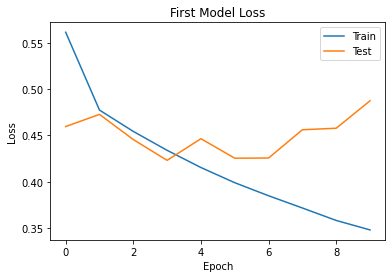

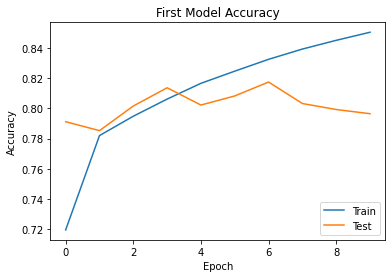

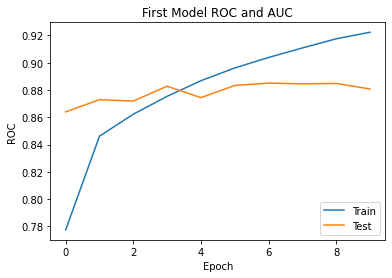

In [20]:
# First model plots

plt.plot(model_1_training.history['loss'])
plt.plot(model_1_training.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('First Model Loss')
plt.legend(['Train','Test'], loc='upper right')
plt.show()

plt.plot(model_1_training.history['accuracy'])
plt.plot(model_1_training.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('First Model Accuracy')
plt.legend(['Train','Test'], loc='lower right')
plt.show()

plt.plot(model_1_training.history['auc_2'])
plt.plot(model_1_training.history['val_auc_2'])
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.title('First Model ROC and AUC')
plt.legend(['Train','Test'], loc='lower right')
plt.show()

For our second model, we will use ReLu activation at our convolutional layers. There will be average pooling instead of max pooling. The number of layers, number of filters, size of filters, and size of pooling will remain the same. We will be able to see if activation or pooling type has any effect on the results.

In [4]:
# Second Model

model_2 = Sequential()

model_2.add(Conv2D(filters = 16, kernel_size = (3,3), activation='relu'))
model_2.add(Conv2D(filters = 16, kernel_size = (3,3), activation='relu'))
model_2.add(AveragePooling2D(pool_size = (2,2)))

model_2.add(Conv2D(filters = 32, kernel_size = (3,3), activation='relu'))
model_2.add(Conv2D(filters = 32, kernel_size = (3,3), activation='relu'))
model_2.add(AveragePooling2D(pool_size = (2,2)))

model_2.add(Conv2D(filters = 64, kernel_size = (3,3)))
model_2.add(Conv2D(filters = 64, kernel_size = (3,3)))
model_2.add(AveragePooling2D(pool_size = (2,2)))

model_2.add(Flatten())
model_2.add(Dense(1, activation = 'sigmoid'))

model_2.build(input_shape = (128, 96, 96, 3))
model_2.compile(loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.AUC()])

2022-11-07 12:09:34.500501: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
# Second model summary

model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (128, 94, 94, 16)         448       
_________________________________________________________________
conv2d_1 (Conv2D)            (128, 92, 92, 16)         2320      
_________________________________________________________________
average_pooling2d (AveragePo (128, 46, 46, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (128, 44, 44, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (128, 42, 42, 32)         9248      
_________________________________________________________________
average_pooling2d_1 (Average (128, 21, 21, 32)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (128, 19, 19, 64)         1

In [6]:
# Second model training

model_2_training = model_2.fit_generator(generator = train_gen, epochs = 10, validation_data = valid_gen)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-07 12:09:55.250728: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1376/1376 [==============================] - 1740s 1s/step - loss: 0.4891 - accuracy: 0.7678 - auc: 0.8358 - val_loss: 0.3992 - val_accuracy: 0.8217 - val_auc: 0.8950
Epoch 2/10
1376/1376 [==============================] - 1024s 744ms/step - loss: 0.4122 - accuracy: 0.8188 - auc: 0.8886 - val_loss: 0.3821 - val_accuracy: 0.8274 - val_auc: 0.9138
Epoch 3/10
1376/1376 [==============================] - 1048s 761ms/step - loss: 0.3826 - accuracy: 0.8349 - auc: 0.9058 - val_loss: 0.3451 - val_accuracy: 0.8513 - val_auc: 0.9231
Epoch 4/10
1376/1376 [==============================] - 1128s 819ms/step - loss: 0.3588 - accuracy: 0.8481 - auc: 0.9179 - val_loss: 0.3246 - val_accuracy: 0.8653 - val_auc: 0.9365
Epoch 5/10
1376/1376 [==============================] - 1041s 757ms/step - loss: 0.3344 - accuracy: 0.8591 - auc: 0.9282 - val_loss: 0.3507 - val_accuracy: 0.8390 - val_auc: 0.9442
Epoch 6/10
1376/1376 [==============================] - 1051s 764ms/step - loss: 0.3148 - accuracy

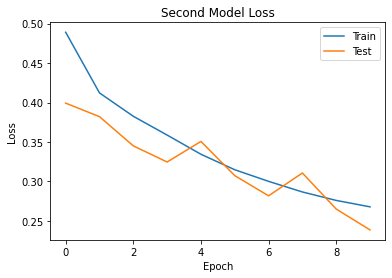

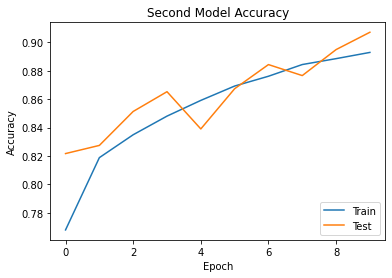

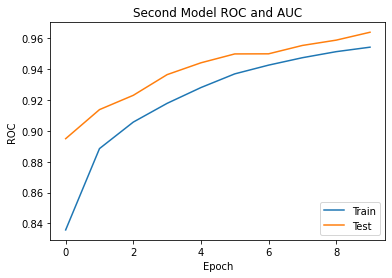

In [7]:
# Second model plots

plt.plot(model_2_training.history['loss'])
plt.plot(model_2_training.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Second Model Loss')
plt.legend(['Train','Test'], loc='upper right')
plt.show()

plt.plot(model_2_training.history['accuracy'])
plt.plot(model_2_training.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Second Model Accuracy')
plt.legend(['Train','Test'], loc='lower right')
plt.show()

plt.plot(model_2_training.history['auc'])
plt.plot(model_2_training.history['val_auc'])
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.title('Second Model ROC and AUC')
plt.legend(['Train','Test'], loc='lower right')
plt.show()

As our second model had higher accuracy on the test data than the original model, our third model will build on the second. We will add droppout and batch normalization at each set of convolutional layers. We will also add an optimizer with a small learning rate.

In [21]:
# Third Model

model_3 = Sequential()

model_3.add(Conv2D(filters = 16, kernel_size = (3,3), activation='relu'))
model_3.add(Conv2D(filters = 16, kernel_size = (3,3), activation='relu'))
model_3.add(AveragePooling2D(pool_size = (2,2)))
model_3.add(Dropout(0.1))
model_3.add(BatchNormalization())

model_3.add(Conv2D(filters = 32, kernel_size = (3,3), activation='relu'))
model_3.add(Conv2D(filters = 32, kernel_size = (3,3), activation='relu'))
model_3.add(AveragePooling2D(pool_size = (2,2)))
model_3.add(Dropout(0.1))
model_3.add(BatchNormalization())

model_3.add(Conv2D(filters = 64, kernel_size = (3,3)))
model_3.add(Conv2D(filters = 64, kernel_size = (3,3)))
model_3.add(AveragePooling2D(pool_size = (2,2)))
model_3.add(Dropout(0.1))
model_3.add(BatchNormalization())

model_3.add(Flatten())
model_3.add(Dense(1, activation = 'sigmoid'))

model_3.build(input_shape = (128, 96, 96, 3))
adam_op = Adam(learning_rate = 0.001)
model_3.compile(loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.AUC()], optimizer = adam_op)

In [22]:
# Third model summary

model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (128, 94, 94, 16)         448       
_________________________________________________________________
conv2d_19 (Conv2D)           (128, 92, 92, 16)         2320      
_________________________________________________________________
average_pooling2d_3 (Average (128, 46, 46, 16)         0         
_________________________________________________________________
dropout (Dropout)            (128, 46, 46, 16)         0         
_________________________________________________________________
batch_normalization (BatchNo (128, 46, 46, 16)         64        
_________________________________________________________________
conv2d_20 (Conv2D)           (128, 44, 44, 32)         4640      
_________________________________________________________________
conv2d_21 (Conv2D)           (128, 42, 42, 32)        

In [23]:
# Third model training

model_3_training = model_3.fit_generator(generator = train_gen, epochs = 10, validation_data = valid_gen)

Epoch 1/10
1376/1376 [==============================] - 1109s 805ms/step - loss: 0.4034 - accuracy: 0.8275 - auc_3: 0.8943 - val_loss: 0.5243 - val_accuracy: 0.7608 - val_auc_3: 0.8062
Epoch 2/10
1376/1376 [==============================] - 1104s 802ms/step - loss: 0.3266 - accuracy: 0.8661 - auc_3: 0.9315 - val_loss: 0.3776 - val_accuracy: 0.8395 - val_auc_3: 0.9046
Epoch 3/10
1376/1376 [==============================] - 1117s 812ms/step - loss: 0.2817 - accuracy: 0.8860 - auc_3: 0.9493 - val_loss: 1.6159 - val_accuracy: 0.7503 - val_auc_3: 0.6976
Epoch 4/10
1376/1376 [==============================] - 1108s 805ms/step - loss: 0.2582 - accuracy: 0.8967 - auc_3: 0.9572 - val_loss: 0.4583 - val_accuracy: 0.8241 - val_auc_3: 0.9155
Epoch 5/10
1376/1376 [==============================] - 1110s 807ms/step - loss: 0.2435 - accuracy: 0.9026 - auc_3: 0.9621 - val_loss: 0.3160 - val_accuracy: 0.8850 - val_auc_3: 0.9462
Epoch 6/10
1376/1376 [==============================] - 1126s 818ms/step - 

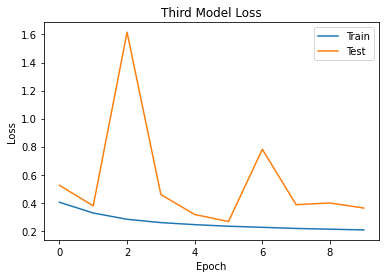

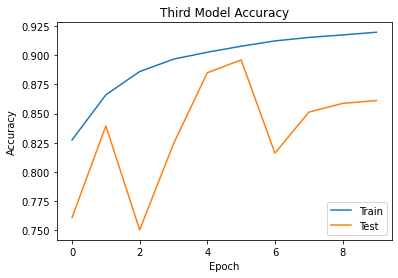

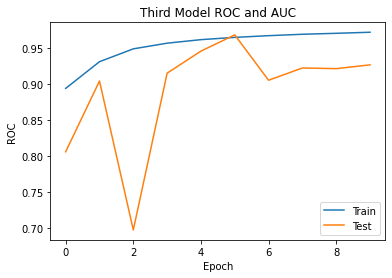

In [24]:
# Third model plots

plt.plot(model_3_training.history['loss'])
plt.plot(model_3_training.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Third Model Loss')
plt.legend(['Train','Test'], loc='upper right')
plt.show()

plt.plot(model_3_training.history['accuracy'])
plt.plot(model_3_training.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Third Model Accuracy')
plt.legend(['Train','Test'], loc='lower right')
plt.show()

plt.plot(model_3_training.history['auc_3'])
plt.plot(model_3_training.history['val_auc_3'])
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.title('Third Model ROC and AUC')
plt.legend(['Train','Test'], loc='lower right')
plt.show()

# Results

In [25]:
m1 = [model_1_training.history['loss'][9],model_1_training.history['val_loss'][9],model_1_training.history['accuracy'][9],model_1_training.history['val_accuracy'][9],model_1_training.history['auc_2'][9],model_1_training.history['val_auc_2'][9]]
m1 = [round(x,2) for x in m1]
m2 = [model_2_training.history['loss'][9],model_2_training.history['val_loss'][9],model_2_training.history['accuracy'][9],model_2_training.history['val_accuracy'][9],model_2_training.history['auc'][9],model_2_training.history['val_auc'][9]]
m2 = [round(x,2) for x in m2]
m3 = [model_3_training.history['loss'][9],model_3_training.history['val_loss'][9],model_3_training.history['accuracy'][9],model_3_training.history['val_accuracy'][9],model_3_training.history['auc_3'][9],model_3_training.history['val_auc_3'][9]]
m3 = [round(x,2) for x in m3]
col_names = ['Train Loss','Test Loss','Train Accuracy','Test Accuracy','Train AUC','Test AUC']
row_names = ['Model 1','Model 2','Model 3']
res = pd.DataFrame([m1,m2,m3],row_names,col_names)
res

,Train Loss,Test Loss,Train Accuracy,Test Accuracy,Train AUC,Test AUC
Model 1,0.35,0.49,0.85,0.80,0.92,0.88
Model 2,0.27,0.24,0.89,0.91,0.95,0.96
Model 3,0.21,0.36,0.92,0.86,0.97,0.93


The table above shows the three metrics 'Loss', 'Accuracy', and 'AUC' for each of the three models on the training and testing data after 10 iterations.

We started with Model 1 making a basic model with a handful of convolutional layers and a few max pooling layers in between ending with a sigmoid activation layer. This yielded an accuracy of 0.80 on the test data after 10 iterations. Model 2 had the same convolutional layers but used ReLU activation, and it used average pooling instead of max. Model 2 produced an accuracy of 0.91 on the test data after 10 iterations, higher than Model 1. Model 3 built on Model 2 and added Dropout and Batch Normalization in between sets of the convolutional layers, and also included an optimizer at the end with a small learning rate. This Model 3 resulted in an accuracy of 0.86 on the testing data after 10 iterations. Comparing the three models, Model 2 had the lowest 'Loss' and the highest 'Accuracy' and 'AUC' on the test data after 10 iterations, suggesting Model 2 is the best model we came up with.

Considering the metrics for Model 2 and Model 3 are close, we will take a look at the metric plots we made for those two models. The Model 3 plots look like they have converged whereas Model 2 plots appear like they will continue to improve with more iterations. Therefore we will use Model 2 for our submission for this competition.

In [8]:
test_df = pd.DataFrame({'id':os.listdir(test_path)})
data_gen_test = ImageDataGenerator(rescale = 1/255)
test_gen = data_gen_test.flow_from_dataframe(dataframe=test_df, directory=test_path, x_col='id', 
                                         y_col='label', batch_size=1, shuffle=False, 
                                         class_mode=None, target_size=(96,96))

Found 57458 validated image filenames.


In [9]:
predictions = model_2.predict(test_gen, verbose = 1)

57458/57458 [==============================] - 513s 9ms/step


In [11]:
sub_df = pd.DataFrame()
sub_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
sub_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
sub_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [12]:
sub_df['label'].value_counts()

0    37430
1    20028
Name: label, dtype: int64

In [13]:
sub_df.to_csv('submission.csv', index=False)

# Conclusion

Model 2 yielded the best results for the data. This model had 3 sets of 2 convolutional layer with an average pooling at the end of each set. The first 2 sets used ReLU activiation. Each set had 16, 32, and 64 filters, respectively, of size 3x3 with a stride of 1. The average pooling size was 2x2 and. The reason for these numbers was because the images were relatively small (96x96 pixels). These 3 sets were followed by a final layer using sigmoid activation. This model resulted in a Loss of 0.24, Accuracy of 0.91, and AUC of 0.96 on the test data after 10 iterations. The metric plots for Model 2 did not fully converged, so in the future with more time we would increase the number of iterations to hopefully get better results. Also in the future we could try a couple more things altering Model 2 slightly to see if we could improve the model.

ReLU activation certainly helped create a better model as well as using average pooling instead of max pooling. Having small filter and pooling sizes seemed to also contribute to better results since the metrics were good.